#Library Imports

In [117]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd


In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Image Loading and Preprocessing

(512, 768)

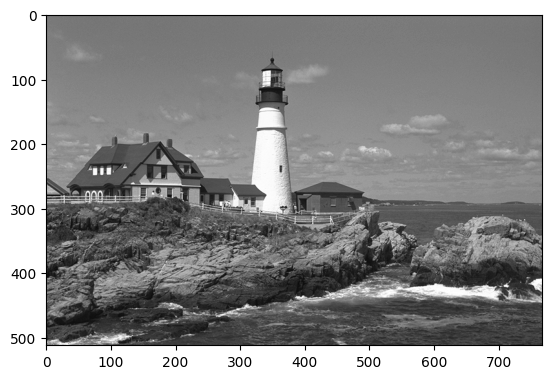

In [119]:
# input rgb image and convert to gray and range from 0-1 to 0-255
image = cv2.imread('/content/drive/MyDrive/lighthouse2.bmp',0)
image = image.astype(np.float32)
h,w = image.shape
plt.imshow(image,cmap = 'gray')
image.shape

#Adding Noise

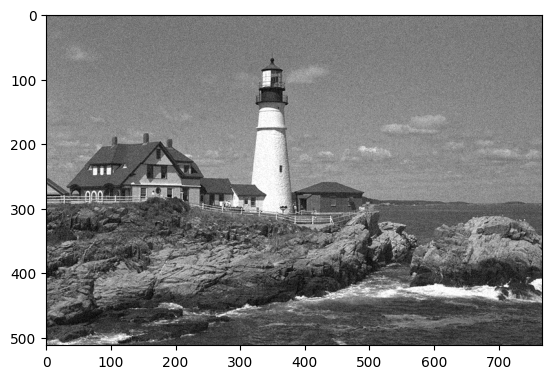

In [120]:
# gaussian noise with var = 100
noise = np.random.normal(0, 10, (h, w))

# adding gaussian noise to image and clipping values (0,255)
noisy_image = np.clip(image + noise, 0, 255)

#noise variance
noise_variance = 100

plt.imshow(noisy_image,cmap = 'gray')

# Applying gaussian Kernels

In [121]:
# Building Gaussain Kernel

def gaussian_kernel(kernel_size,std_dev,noise_variance):
  # Generally gaussian kernel size is odd for symmetricity
  if kernel_size % 2 == 0 :
    raise ValueError("Kernel size must be odd for symmetricity")

  # initialize kernel matrix
  kernel = np.zeros((kernel_size,kernel_size))

  # filling kernel matrix
  for i in range(kernel_size):
    for j in range(kernel_size):
      # mu is center pixel cordinate
      mu = int(kernel_size/2)
      z = ((i - mu) ** 2 + (j - mu) ** 2) / (2 * std_dev ** 2)
      # gaussian function
      kernel[i,j] = np.exp(-z) *(1 / (2 * np.pi * std_dev**2))**0.5

  # Nomalisation
  kernel /= np.sum(kernel)

  #varince of kernel
  temp = np.array(kernel)
  temp[int(kernel_size/2),int(kernel_size/2)] -= 1
  var_z1 = np.sum(temp**2)*noise_variance

  return kernel,var_z1

In [122]:
# Convultion of image and kernel

def convulution(img,kernel):
    # convolving with image
    convolved_image = cv2.filter2D(img, -1, kernel)  # -1 indcates  same depth(data type in cv2) for output and source image
    return convolved_image

#Function for mse

In [123]:
# Mean Squared Error

def mean_squared_error(image1,image2):
  mse = np.mean((image1 - image2)**2)
  return mse


#Qns --> 1

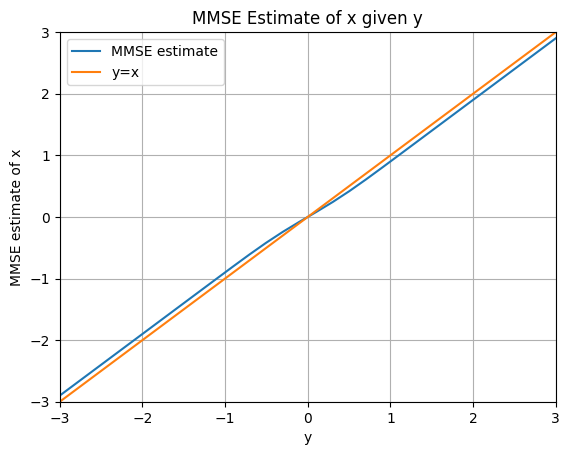

In [124]:
# Define parameters
sigma_X = 1
sigma_Z = np.sqrt(0.1)

# Define PDF of X
def f_X(x):
    return 1/(2*sigma_X) * np.exp(-np.abs(x)/sigma_X)

# Define PDF of Y given X
def f_Y_given_X(y, x):
    return 1/(np.sqrt(2*np.pi)*sigma_Z) * np.exp(-((y-x)**2)/(2*sigma_Z**2))

# Define PDF of Y
def f_Y(y):
    x_values = np.linspace(-10, 10, 1000)
    return np.trapz(f_X(x_values) * f_Y_given_X(y, x_values), x_values)

# Compute MMSE estimate for a given y
def compute_MMSE_estimate(y):
    x_values = np.linspace(-10, 10, 1000)
    return np.trapz(x_values * f_X(x_values) * f_Y_given_X(y, x_values) / f_Y(y), x_values)

# Range of y values
y_values = np.linspace(-10, 10, 100)

# Compute MMSE estimate for each y
MMSE_estimates = [compute_MMSE_estimate(y) for y in y_values]

# Plot MMSE estimate as a function of y
plt.plot(y_values, MMSE_estimates, label='MMSE estimate')
plt.xlabel('y')
plt.ylabel('MMSE estimate of x')
plt.title('MMSE Estimate of x given y')
plt.grid(True)

# Plot y=x line
plt.plot(y_values, y_values, label='y=x')

# Add legend
plt.legend()

# Zoom into the region where the curves are close
plt.xlim(-3, 3)  # Set x-axis limits
plt.ylim(-3, 3)  # Set y-axis limits

# Show plot
plt.show()


#Qns --> 2.1 Low Pass Gaussian

In [125]:
import pandas as pd

filter_lengths = [3, 7, 11]
std_deviations = [0.1, 1, 2, 4, 8]

# Create an empty list to store data
data = []

# Iterate through each filter length
for length in filter_lengths:
    # For each filter length, iterate through each standard deviation
    for std in std_deviations:
        # Append the combination of filter length and standard deviation as a tuple to the data list
        data.append((length, std))

# Create a DataFrame from the list of tuples
df = pd.DataFrame(data, columns=['Filter Length', 'Std_Dev'])

# Group by Filter Length
grouped = df.groupby('Filter Length')

# Iterate over groups and display
for name, group in grouped:
    print(f"Filter Length = {name}")
    print(group.drop(columns=['Filter Length']))
    print()


Filter Length = 3
   Std_Dev
0      0.1
1      1.0
2      2.0
3      4.0
4      8.0

Filter Length = 7
   Std_Dev
5      0.1
6      1.0
7      2.0
8      4.0
9      8.0

Filter Length = 11
    Std_Dev
10      0.1
11      1.0
12      2.0
13      4.0
14      8.0



In [126]:
# Define sets for filter length and standard deviations
filter_lengths = [3, 7, 11]
std_deviations = [0.1, 1, 2, 4, 8]

LOW_PS_MSE = []

best_mse = float('inf')
best_filter_length = None
best_std_deviation = None
best_denoised_image = None

# Iterate over filter lengths and standard deviations
for filter_length in filter_lengths:
    print(f"Filter lenth = {filter_length}")
    for std_deviation in std_deviations:
        # Apply low pass Gaussian filter
        kernel,_ = gaussian_kernel(filter_length,std_deviation,noise_variance)
        denoised_image = convulution(noisy_image,kernel)
        # Compute MSE
        mse = mean_squared_error(image, denoised_image)
        print(f"mse for std_dev: {std_deviation} is {mse}")
        LOW_PS_MSE.append(mse)
        # Update best parameters if MSE is lower
        if mse < best_mse:
            best_mse = mse
            best_filter_length = filter_length
            best_std_deviation = std_deviation
            best_denoised_image = denoised_image

# Print best parameters and MSE
print("Best filter length:", best_filter_length)
print("Best standard deviation:", best_std_deviation)
print("Best MSE:", best_mse)
df['LOW_PS_MSE'] = LOW_PS_MSE

Filter lenth = 3
mse for std_dev: 0.1 is 99.02157632962651
mse for std_dev: 1 is 89.42906498987566
mse for std_dev: 2 is 110.14444528520768
mse for std_dev: 4 is 115.51971793040047
mse for std_dev: 8 is 116.86538766708907
Filter lenth = 7
mse for std_dev: 0.1 is 99.02157632962651
mse for std_dev: 1 is 114.74184914690083
mse for std_dev: 2 is 218.14676101864234
mse for std_dev: 4 is 266.56969588845715
mse for std_dev: 8 is 280.1447303944879
Filter lenth = 11
mse for std_dev: 0.1 is 99.02157632962643
mse for std_dev: 1 is 114.79152129898364
mse for std_dev: 2 is 234.00571895144535
mse for std_dev: 4 is 327.3761508159645
mse for std_dev: 8 is 361.4719304023763
Best filter length: 3
Best standard deviation: 1
Best MSE: 89.42906498987566


Text(0.5, 1.0, 'Best Denoised Light House')

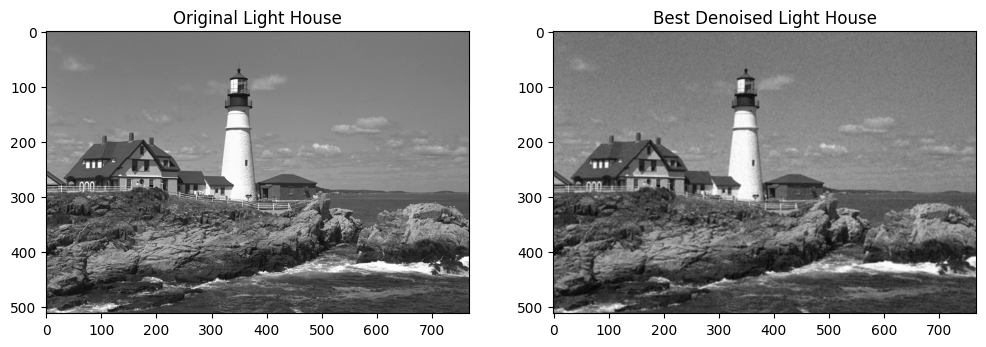

In [127]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first image on the left
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Light House')

# Plot the second image on the right
axes[1].imshow(best_denoised_image, cmap='gray')
axes[1].set_title('Best Denoised Light House')




---



---

#Qns --> 2.2 ADAPTIVE MMSE

In [128]:
def adaptive_mmse(high_pass_noisy_image, patch_size, overlap, noise_variance, var_z1, low_pass_image):
    stride = patch_size - overlap
    rows, cols = high_pass_noisy_image.shape
    best_estimated_image = np.zeros_like(high_pass_noisy_image)
    # Compute the number of times each pixel is updated due to overlapping patches
    num_updates = np.zeros_like(high_pass_noisy_image)

    for i in range(0, rows-patch_size+1, stride):
        for j in range(0, cols-patch_size+1, stride):
            num_updates[i:i+patch_size, j:j+patch_size] += 1
            patch = high_pass_noisy_image[i:i+patch_size, j:j+patch_size]
            var_y1_patch = np.var(patch)
            var_x1 = var_y1_patch - var_z1
            if var_x1 + var_z1 == 0:
              print(var_z1,var_x1)
            best_estimated_patch = (var_x1/(var_x1 + var_z1))*patch
            best_estimated_image[i:i+patch_size, j:j+patch_size] += best_estimated_patch

    best_estimated_image = (best_estimated_image / num_updates) + low_pass_image
    return best_estimated_image


In [ ]:
# Define sets for filter length and standard deviations
filter_lengths = [3, 7, 11]
std_deviations = [0.1, 1, 2, 4, 8]

ADP_MSE = []

best_mse = float('inf')
best_filter_length = None
best_std_deviation = None
best_estimated_image = None

patch_size = 32
overlap = 16
noise_variance = 100

# Iterate over filter lengths and standard deviations
for filter_length in filter_lengths:
    print(f"Filter lenth = {filter_length}")
    for std_deviation in std_deviations:
        # Apply low pass Gaussian filter
        kernel,var_z1 = gaussian_kernel(filter_length,std_deviation,noise_variance)
        low_pass_image = convulution(noisy_image,kernel)
        high_pass_image = noisy_image - low_pass_image

        estimated_image = adaptive_mmse(high_pass_image, patch_size, overlap, noise_variance,var_z1,low_pass_image)
        mse = mean_squared_error(image, estimated_image)
        ADP_MSE.append(mse)
        print(f"MSE for Adaptive MMSE for std_dev = {std_deviation} is --> : {mse}")
        # Compute MSE
        # print(f"mse for std_dev: {std_deviation} is {mse}")
        # Update best parameters if MSE is lower
        if mse < best_mse:
            best_mse = mse
            best_filter_length = filter_length
            best_std_deviation = std_deviation
            best_estimated_image = estimated_image

# Print best parameters and MSE
print("Best filter length:", best_filter_length)
print("Best standard deviation:", best_std_deviation)
print("Best MSE:", best_mse)
df['ADP_MSE'] = ADP_MSE

Text(0.5, 1.0, 'ADAPTIVE MMSE Light House')

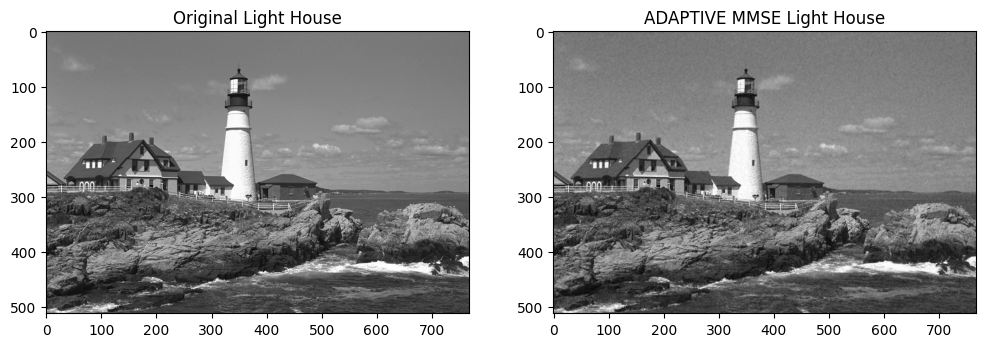

In [130]:
# Display original and denoised images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first image on the left
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Light House')

# Plot the second image on the right
axes[1].imshow(best_estimated_image, cmap='gray')
axes[1].set_title('ADAPTIVE MMSE Light House')

#Qns --> 2.3 Shrinkage Estimate

In [131]:
print(df)

    Filter Length  Std_Dev  LOW_PS_MSE    ADP_MSE
0               3      0.1   99.021576        NaN
1               3      1.0   89.429065  41.696719
2               3      2.0  110.144445  41.655622
3               3      4.0  115.519718  41.809636
4               3      8.0  116.865388  41.856411
5               7      0.1   99.021576        NaN
6               7      1.0  114.741849  41.748560
7               7      2.0  218.146761  44.084133
8               7      4.0  266.569696  45.549010
9               7      8.0  280.144730  45.967781
10             11      0.1   99.021576  99.021576
11             11      1.0  114.791521  41.748585
12             11      2.0  234.005719  44.537547
13             11      4.0  327.376151  47.239905
14             11      8.0  361.471930  48.158560


In [132]:
# Best value of t for each each patch
def best_threshold(patch,var_z1):
  possible_thresholds = np.arange(256)
  best_t = None
  sure = float('inf')
  for t in possible_thresholds:
    t_array = np.full_like(patch, t)
    temp_patch = np.where(patch < t_array, patch, t_array)
    f = np.sum(temp_patch ** 2)

    temp = -2*var_z1*np.sum(np.abs(patch) <= t) + f

    if sure > temp:
      sure = temp
      best_t = t

  return best_t

In [133]:
def sure_skrinkage(y1,patch_size,stride,var_z1,low_pass_image):
  best_sure_estimated_image = np.zeros_like(y1)
  num_updates = np.zeros_like(y1)
  rows,cols = y1.shape

  for i in range(0, rows-patch_size+1, stride):
      for j in range(0, cols-patch_size+1, stride):
          num_updates[i:i+patch_size, j:j+patch_size] += 1
          patch = y1[i:i+patch_size, j:j+patch_size]
          optimal_t = best_threshold(patch,var_z1)
          best_sure_estimated_patch = np.sign(patch)*np.where((np.abs(patch) - optimal_t) > 0,(np.abs(patch) - optimal_t),0)
          best_sure_estimated_image[i:i+patch_size, j:j+patch_size] = best_sure_estimated_patch

  best_sure_estimated_image /= num_updates
  best_sure_estimated_image += low_pass_image
  return best_sure_estimated_image

In [135]:
# Define sets for filter length and standard deviations
filter_lengths = [3, 7, 11]
std_deviations = [0.1, 1, 2, 4, 8]

SURE_MSE = []

best_mse = float('inf')
best_filter_length = None
best_std_deviation = None
best_estimated_image = None

patch_size = 32
stride = 32
noise_variance = 100

# Iterate over filter lengths and standard deviations
for filter_length in filter_lengths:
    print(f"Filter lenth = {filter_length}")
    for std_deviation in std_deviations:
        # Apply low pass Gaussian filter
        kernel,var_z1 = gaussian_kernel(filter_length,std_deviation,noise_variance)
        low_pass_image = convulution(noisy_image,kernel)
        high_pass_image = noisy_image - low_pass_image

        estimated_image = sure_skrinkage(high_pass_image, patch_size, stride,var_z1,low_pass_image)
        mse = mean_squared_error(image, estimated_image)
        SURE_MSE.append(mse)
        print(f"MSE for SURE MMSE for std_dev = {std_deviation} is --> : {mse}")
        # Compute MSE
        # print(f"mse for std_dev: {std_deviation} is {mse}")
        # Update best parameters if MSE is lower
        if mse < best_mse:
            best_mse = mse
            best_filter_length = filter_length
            best_std_deviation = std_deviation
            best_estimated_image = estimated_image

# Print best parameters and MSE
print("Best filter length:", best_filter_length)
print("Best standard deviation:", best_std_deviation)
print("Best MSE:", best_mse)
df['SURE_MSE'] = SURE_MSE

Filter lenth = 3
MSE for SURE MMSE for std_dev = 0.1 is --> : 99.02157632962651
MSE for SURE MMSE for std_dev = 1 is --> : 49.55428387127734
MSE for SURE MMSE for std_dev = 2 is --> : 54.494135388315755
MSE for SURE MMSE for std_dev = 4 is --> : 55.48111789484051
MSE for SURE MMSE for std_dev = 8 is --> : 55.9415495273205
Filter lenth = 7
MSE for SURE MMSE for std_dev = 0.1 is --> : 99.02157632962651
MSE for SURE MMSE for std_dev = 1 is --> : 50.79796677234115
MSE for SURE MMSE for std_dev = 2 is --> : 58.30005949509687
MSE for SURE MMSE for std_dev = 4 is --> : 60.79681724238475
MSE for SURE MMSE for std_dev = 8 is --> : 61.487134466714885
Filter lenth = 11
MSE for SURE MMSE for std_dev = 0.1 is --> : 99.02157632962651
MSE for SURE MMSE for std_dev = 1 is --> : 50.86828668873372
MSE for SURE MMSE for std_dev = 2 is --> : 59.13898586600871
MSE for SURE MMSE for std_dev = 4 is --> : 62.82874270786447
MSE for SURE MMSE for std_dev = 8 is --> : 64.20284024074674
Best filter length: 3
Best

Text(0.5, 1.0, 'SURE SHRINKAGE Light House')

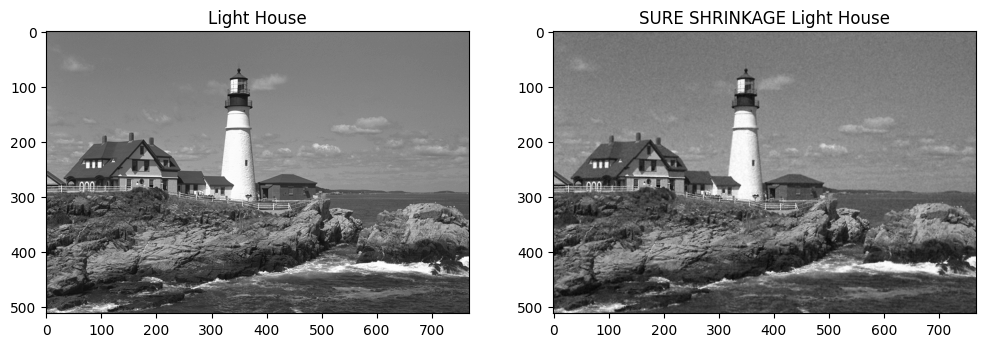

In [136]:

# Display original and denoised images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first image on the left
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Light House')

# Plot the second image on the right
axes[1].imshow(best_estimated_image, cmap='gray')
axes[1].set_title('SURE SHRINKAGE Light House')

In [137]:
print(df)

    Filter Length  Std_Dev  LOW_PS_MSE    ADP_MSE   SURE_MSE
0               3      0.1   99.021576        NaN  99.021576
1               3      1.0   89.429065  41.696719  49.554284
2               3      2.0  110.144445  41.655622  54.494135
3               3      4.0  115.519718  41.809636  55.481118
4               3      8.0  116.865388  41.856411  55.941550
5               7      0.1   99.021576        NaN  99.021576
6               7      1.0  114.741849  41.748560  50.797967
7               7      2.0  218.146761  44.084133  58.300059
8               7      4.0  266.569696  45.549010  60.796817
9               7      8.0  280.144730  45.967781  61.487134
10             11      0.1   99.021576  99.021576  99.021576
11             11      1.0  114.791521  41.748585  50.868287
12             11      2.0  234.005719  44.537547  59.138986
13             11      4.0  327.376151  47.239905  62.828743
14             11      8.0  361.471930  48.158560  64.202840
